### Import Statements

In [52]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

In [2]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

### Read the Data

In [3]:
data = pd.read_csv("../clean_data/FinalData_for_Models.csv")

In [4]:
data.rename(columns={'Unnamed: 0':'pickup_time'}, inplace=True)

In [5]:
data.head()

,pickup_time,num_pickups,num_passengers,missing_dt,temp,temp_min,temp_max,humidity,wind_speed,weather_main,weather_description,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights
0,2014-01-01 00:00:00-05:00,107.0,210.0,False,269.27,267.59,270.93,80.0,3.0,clear,sky is clear,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0
1,2014-01-01 01:00:00-05:00,34.0,45.0,False,268.90,267.04,270.93,80.0,2.0,clear,sky is clear,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0
2,2014-01-01 02:00:00-05:00,34.0,70.0,False,268.48,266.48,270.37,57.0,3.0,clear,sky is clear,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0
3,2014-01-01 03:00:00-05:00,12.0,18.0,False,268.33,265.93,270.37,80.0,3.0,clear,sky is clear,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0
4,2014-01-01 04:00:00-05:00,25.0,37.0,False,268.10,265.37,270.37,80.0,3.0,clear,sky is clear,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0


In [6]:
## ignoring the missing data values in 2016
data = data.loc[data.missing_dt == False, :]
data.drop("missing_dt", axis=1, inplace=True)

In [7]:
data.shape

(30647, 20)

### Creating Dummies for Weather Data

In [8]:
## for weather main
data_wm_dummies = data['weather_main'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [9]:
## for weather description
data_wd_dummies = data['weather_description'].str.split(",").str.join("*").str.get_dummies(sep='*')

In [10]:
data.drop(["weather_main", "weather_description"], axis=1, inplace=True)

In [11]:
data = pd.concat([data, data_wm_dummies], axis=1)

In [12]:
data.shape

(30647, 24)

In [13]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,True,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,True,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


** Remark : We can choose to only include weather main categories or weather description also alongwith <br> TRY BOTH OF THEM FOR MODELS **

### Modifying Boolean Data Columns (Holiday)

In [14]:
data['holiday'] = data.holiday.astype(int)

In [15]:
data.head()

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,Hour,Day,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,70.0,268.48,266.48,270.37,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,18.0,268.33,265.93,270.37,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,0.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,37.0,268.10,265.37,270.37,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


### Time Feature

In [16]:
data.rename(columns={'Hour':'HourOfDay'}, inplace=True)
data.rename(columns={'Day':'DayOfWeek'}, inplace=True)

In [17]:
data.head(2)

,pickup_time,num_pickups,num_passengers,temp,temp_min,temp_max,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Avg_Delay_Departing,Cancelled_Arriving_Flights,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,210.0,269.27,267.59,270.93,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,45.0,268.90,267.04,270.93,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0


In [18]:
data.shape

(30647, 24)

### Drop the Number of Passengers

In [19]:
data.drop(["num_passengers"], axis=1, inplace=True)

### Dropping cancelled arriving flights as they should have no influence in pickups at LGA

In [20]:
## as they will probably have no predictive value
data.drop(['Cancelled_Arriving_Flights'], axis=1, inplace=True)

In [21]:
data.drop(['Avg_Delay_Departing'], axis=1, inplace=True)

### Dropping Temp_Mix and Temp_Max as we already have Temp

In [22]:
data.drop(['temp_min', 'temp_max'], axis=1, inplace=True)

In [23]:
data.head()

,pickup_time,num_pickups,temp,humidity,wind_speed,Passengers,Month,HourOfDay,DayOfWeek,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0,2,1,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,1,2,1,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,2,2,1,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,3,2,1,0.0,291.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,4,2,1,0.0,0.0,0.0,1,0,0,0,0,0


### Dropping Month, HourOfDay, DayOfWeek

In [24]:
data.drop(['Month', 'HourOfDay', 'DayOfWeek'], axis=1, inplace=True)

In [25]:
data.head()

,pickup_time,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
0,2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0
1,2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2,2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
3,2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0
4,2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0


In [26]:
data.set_index("pickup_time", inplace=True)

## LSTM models start from here

In [27]:
data.head()

,num_pickups,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm
pickup_time,,,,,,,,,,,,,,,
2014-01-01 00:00:00-05:00,107.0,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 01:00:00-05:00,34.0,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 02:00:00-05:00,34.0,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0
2014-01-01 03:00:00-05:00,12.0,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0
2014-01-01 04:00:00-05:00,25.0,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0


In [28]:
## the labels (num_pickups)
num_pickups = data.num_pickups
data.drop("num_pickups", axis=1, inplace=True)

## LSTM RNN with Keras

In [29]:
# fix random seed for reproducibility
np.random.seed(7)

In [30]:
# convert series to supervised learning
# adapted from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

In [31]:
# need to recombine X and y
features_and_target = pd.concat([data, num_pickups], axis=1)

In [32]:
features_and_target.head()

,temp,humidity,wind_speed,Passengers,holiday,precip_in,Avg_Delay_Arriving,Cancelled_Departing_Flights,clear,clouds,fog,rain,snow,thunderstorm,num_pickups
pickup_time,,,,,,,,,,,,,,,
2014-01-01 00:00:00-05:00,269.27,80.0,3.0,108.0,1,0.0,0.0,0.0,1,0,0,0,0,0,107.0
2014-01-01 01:00:00-05:00,268.90,80.0,2.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,34.0
2014-01-01 02:00:00-05:00,268.48,57.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,34.0
2014-01-01 03:00:00-05:00,268.33,80.0,3.0,0.0,1,0.0,291.0,0.0,1,0,0,0,0,0,12.0
2014-01-01 04:00:00-05:00,268.10,80.0,3.0,0.0,1,0.0,0.0,0.0,1,0,0,0,0,0,25.0


In [33]:
features_and_target.shape

(30647, 15)

In [34]:
values = features_and_target.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

n_hours = 4

# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]

reframed.head()

,var1(t-4),var2(t-4),var3(t-4),var4(t-4),var5(t-4),var6(t-4),var7(t-4),var8(t-4),var9(t-4),var10(t-4),var11(t-4),var12(t-4),var13(t-4),var14(t-4),var15(t-4),var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),var11(t-3),var12(t-3),var13(t-3),var14(t-3),var15(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var6(t-2),var7(t-2),var8(t-2),var9(t-2),var10(t-2),var11(t-2),var12(t-2),var13(t-2),var14(t-2),var15(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t)
4,0.321133,0.80,0.166667,0.038654,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.083725,0.314709,0.80,0.111111,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.307417,0.57,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304812,0.8,0.166667,0.000000,1.0,0.0,0.255937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300819,0.8,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562
5,0.314709,0.80,0.111111,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.307417,0.57,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304812,0.80,0.166667,0.000000,1.0,0.0,0.255937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300819,0.8,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.8,0.055556,0.086972,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520
6,0.307417,0.57,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.026604,0.304812,0.80,0.166667,0.000000,1.0,0.0,0.255937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300819,0.80,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.8,0.055556,0.086972,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.8,0.055556,0.050465,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955
7,0.304812,0.80,0.166667,0.000000,1.0,0.0,0.255937,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.009390,0.300819,0.80,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.80,0.055556,0.086972,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.8,0.055556,0.050465,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955,0.291965,0.8,0.055556,0.256621,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016432
8,0.300819,0.80,0.166667,0.000000,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.019562,0.299430,0.80,0.055556,0.086972,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.012520,0.297347,0.80,0.055556,0.050465,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.010955,0.291965,0.8,0.055556,0.256621,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.016432,0.293354,0.8,0.000000,0.285254,1.0,0.0,0.002345,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.073552


In [35]:
reframed.shape

(30643, 75)

In [36]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 60) 26280 (26280,)
(26280, 4, 15) (26280,) (4363, 4, 15) (4363,)


In [37]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 4363 samples
Epoch 1/100
 - 2s - loss: 0.0854 - val_loss: 0.0575
Epoch 2/100
 - 1s - loss: 0.0636 - val_loss: 0.0532
Epoch 3/100
 - 2s - loss: 0.0594 - val_loss: 0.0504
Epoch 4/100
 - 2s - loss: 0.0568 - val_loss: 0.0487
Epoch 5/100
 - 2s - loss: 0.0555 - val_loss: 0.0478
Epoch 6/100
 - 2s - loss: 0.0548 - val_loss: 0.0470
Epoch 7/100
 - 2s - loss: 0.0539 - val_loss: 0.0462
Epoch 8/100
 - 2s - loss: 0.0529 - val_loss: 0.0465
Epoch 9/100
 - 2s - loss: 0.0519 - val_loss: 0.0477
Epoch 10/100
 - 2s - loss: 0.0510 - val_loss: 0.0486
Epoch 11/100
 - 2s - loss: 0.0501 - val_loss: 0.0483
Epoch 12/100
 - 1s - loss: 0.0495 - val_loss: 0.0479
Epoch 13/100
 - 2s - loss: 0.0488 - val_loss: 0.0459
Epoch 14/100
 - 2s - loss: 0.0481 - val_loss: 0.0448
Epoch 15/100
 - 1s - loss: 0.0476 - val_loss: 0.0447
Epoch 16/100
 - 1s - loss: 0.0472 - val_loss: 0.0438
Epoch 17/100
 - 2s - loss: 0.0469 - val_loss: 0.0433
Epoch 18/100
 - 2s - loss: 0.0467 - val_loss: 0.0430
Epoch 

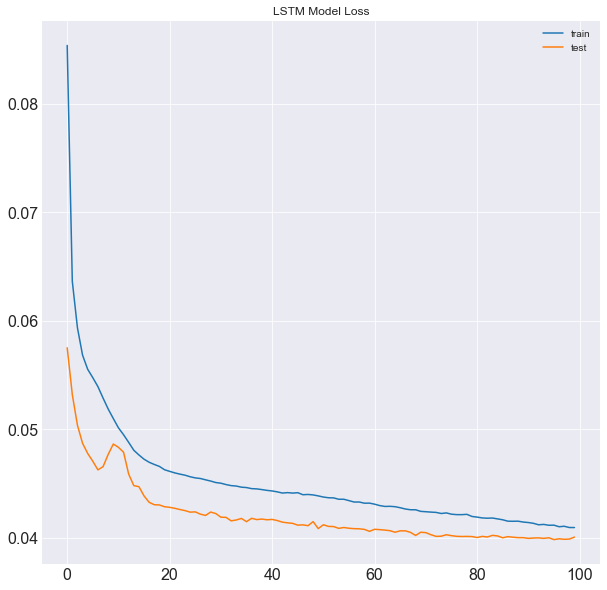

In [38]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');
plt.savefig("../images/lstm_model_loss.png")

In [39]:
# make a prediction
yhat = model.predict(test_X)

In [40]:
yhat

array([[ 0.0079813 ],
       [ 0.02128335],
       [ 0.00991899],
       ..., 
       [ 0.37040731],
       [ 0.3290253 ],
       [ 0.3782143 ]], dtype=float32)

In [41]:
test_X.shape

(4363, 4, 15)

In [42]:
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

In [43]:
test.shape

(4363, 75)

In [44]:
test_X.shape

(4363, 60)

In [45]:
# invert scaling for forecast
inv_yhat = np.concatenate((test[:, 60:74], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 60:74], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [46]:
inv_y

array([  41.99999619,    4.        ,    5.        , ...,  433.00003052,
        384.        ,  335.        ], dtype=float32)

In [47]:
inv_yhat

array([  10.20010185,   27.20012283,   12.67646694, ...,  473.3805542 ,
        420.49432373,  483.35787964], dtype=float32)

In [48]:
test[-1]

array([ 0.89565229,  0.42999998,  0.16666667,  0.10808876,  0.        ,
        0.        ,  0.0360598 ,  0.06896552,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  1.        ,  0.35758999,
        0.88141537,  0.64999998,  0.33333334,  0.43056548,  0.        ,
        0.        ,  0.03430079,  0.06896552,  0.        ,  1.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.28247261,
        0.85832357,  0.64999998,  0.27777779,  0.41445956,  0.        ,
        0.        ,  0.06166325,  0.10344827,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.33881065,
        0.84703779,  0.64999998,  0.22222222,  0.39942732,  0.        ,
        0.        ,  0.08069481,  0.03448276,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.30046949,
        0.82950211,  0.64999998,  0.3888889 ,  0.08947745,  0.        ,
        0.        ,  0.10739764,  0.        ,  0.        ,  0.  

In [49]:
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

In [64]:
# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

R2:   0.912560481479


In [65]:
# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

MAE:  51.1814


In [66]:
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

RMSE: 71.83530833397668


In [55]:
results = pd.DataFrame()
results['prediction'] = inv_yhat
results['actual'] = inv_y

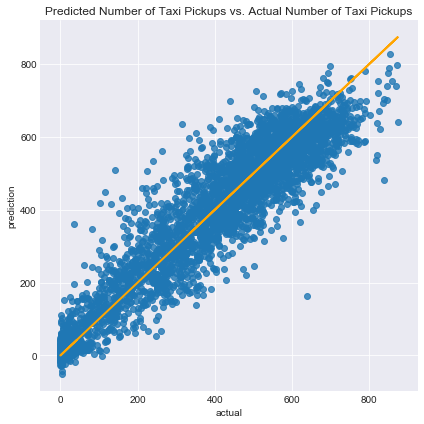

In [56]:
import seaborn as sns
sns.lmplot(x='actual',y='prediction',data=results,fit_reg=False, size=6)
plt.plot(results['actual'], results['actual'], color="orange", linewidth=2)

plt.title("Predicted Number of Taxi Pickups vs. Actual Number of Taxi Pickups")
plt.tight_layout()
plt.savefig("../images/lstm_model_pred_actual.png")

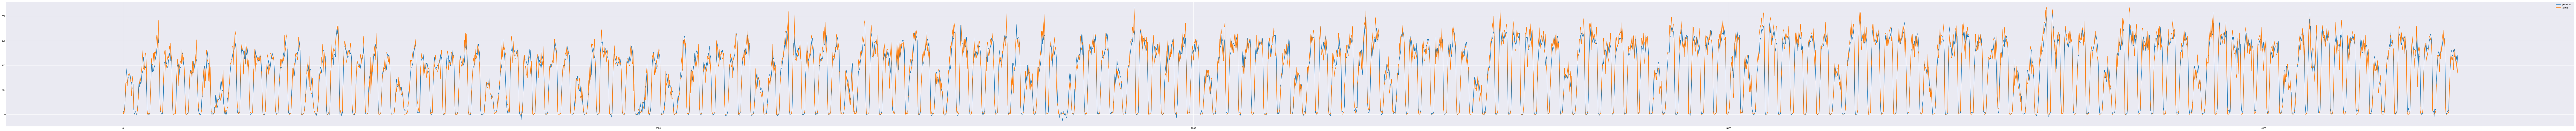

In [57]:
results.plot(figsize=(200,10));

In [58]:
results.head()

,prediction,actual
0,10.200102,41.999996
1,27.200123,4.000000
2,12.676467,5.000000
3,60.718056,46.000000
4,114.593163,118.000000


In [59]:
results.shape

(4363, 2)

### Save results to csv for animation

In [58]:
features_and_target.index[-4363:]

Index(['2016-12-31 04:00:00-05:00', '2016-12-31 05:00:00-05:00',
       '2016-12-31 06:00:00-05:00', '2016-12-31 07:00:00-05:00',
       '2016-12-31 08:00:00-05:00', '2016-12-31 09:00:00-05:00',
       '2016-12-31 10:00:00-05:00', '2016-12-31 11:00:00-05:00',
       '2016-12-31 12:00:00-05:00', '2016-12-31 13:00:00-05:00',
       ...
       '2017-06-30 14:00:00-04:00', '2017-06-30 15:00:00-04:00',
       '2017-06-30 16:00:00-04:00', '2017-06-30 17:00:00-04:00',
       '2017-06-30 18:00:00-04:00', '2017-06-30 19:00:00-04:00',
       '2017-06-30 20:00:00-04:00', '2017-06-30 21:00:00-04:00',
       '2017-06-30 22:00:00-04:00', '2017-06-30 23:00:00-04:00'],
      dtype='object', name='pickup_time', length=4363)

In [354]:
results.index = pd.Series(features_and_target.index[-4363:]).apply(lambda x: x.split(":00-0")[0])

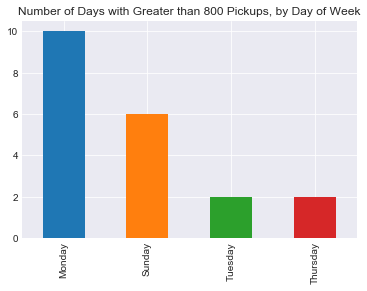

In [389]:
pickups_gte_800 = results[results['actual'] > 800].copy()
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
pickups_gte_800['day_of_week'] = list(pd.Series(pickups_gte_800.index).apply(lambda x: days_of_week[pd.to_datetime(x).dayofweek]))

pickups_gte_800['day_of_week'].value_counts().plot(kind='bar', title='Number of Days with Greater than 800 Pickups, by Day of Week')

In [404]:
pickups_gte_800

,prediction,actual,day_of_week
pickup_time,,,
2017-02-20 23:00,520.374817,838.000061,Monday
2017-02-21 10:00,541.660522,816.000000,Tuesday
2017-03-09 22:00,623.347290,827.999939,Thursday
2017-03-12 22:00,644.061218,819.000000,Sunday
2017-03-19 22:00,646.601379,873.000061,Sunday
2017-04-06 23:00,703.054871,845.000061,Thursday
2017-04-16 22:00,659.527710,802.000000,Sunday
2017-04-17 10:00,774.341309,847.000000,Monday
2017-05-07 22:00,730.109253,823.000000,Sunday


In [405]:
descriptions = [
    "President's Day",
    "Day after President's Day",
    "",
    "",
    "",
    "",
    "Easter",
    "Easter Monday",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    "",
    ""
]

In [406]:
pickups_gte_800['description'] = descriptions

In [407]:
pickups_gte_800

,prediction,actual,day_of_week,description
pickup_time,,,,
2017-02-20 23:00,520.374817,838.000061,Monday,President's Day
2017-02-21 10:00,541.660522,816.000000,Tuesday,Day after President's Day
2017-03-09 22:00,623.347290,827.999939,Thursday,
2017-03-12 22:00,644.061218,819.000000,Sunday,
2017-03-19 22:00,646.601379,873.000061,Sunday,
2017-04-06 23:00,703.054871,845.000061,Thursday,
2017-04-16 22:00,659.527710,802.000000,Sunday,Easter
2017-04-17 10:00,774.341309,847.000000,Monday,Easter Monday
2017-05-07 22:00,730.109253,823.000000,Sunday,


In [61]:
#results.to_csv("../sketches/lstm_results.csv")

In [62]:
results.head()

,prediction,actual
pickup_time,,
2016-12-31 04:00,1.948788,41.999996
2016-12-31 05:00,27.304510,4.000000
2016-12-31 06:00,10.059940,5.000000
2016-12-31 07:00,59.568806,46.000000
2016-12-31 08:00,114.684738,118.000000


In [63]:
results.describe()

,prediction,actual
count,4363.000000,4363.000000
mean,334.402832,338.180603
std,234.744965,242.959488
min,-58.227066,0.000000
25%,60.810863,53.500000
50%,385.960358,386.000031
75%,542.955811,546.000000
max,829.367615,873.000061
